## regime-switching autoregressive conditional heteroscedasticity (SWARCH) model

In [30]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pandas_datareader.data as web
from datetime import datetime
from statsmodels.tsa.regime_switching.markov_regression import MarkovRegression
from arch import arch_model
import yfinance as yf
from datetime import datetime, timedelta

In [71]:
def fit_markov_switching_model(returns, k_regimes=3):
    """
    Fit a Markov-switching model to the return series
    """
    # Center the returns (the model will estimate the regime-specific means)
    returns_centered = returns - returns.mean()

    # Fit the model
    # Note: This is a simplified version; the paper uses a more complex SWARCH model
    model = MarkovRegression(returns_centered, k_regimes=k_regimes,
                            trend='c', switching_variance=True)
    result = model.fit()

    return result

def compute_regime_probabilities(model_result, returns):
    """
    Compute smoothed probabilities of each regime
    """
    smoothed_probs = model_result.smoothed_marginal_probabilities
    regime_probs = pd.DataFrame(smoothed_probs,
                              index=returns.index,
                              columns=[f'regime_{i}' for i in range(model_result.k_regimes)])

    # Rename columns to be more descriptive
    regime_probs.columns = ['low_volatility', 'medium_volatility', 'high_volatility']

    return regime_probs

def fit_swarch_model(returns):
    """
    Implementation of a simplified SWARCH model as described in the paper

    Note: A complete SWARCH model would be more complex and require custom implementation.
    This is a simplified version using standard GARCH with regime-switching detection.
    """
    # Step 1: Fit a standard GARCH model to get volatility estimates
    # Make sure returns is a Series with no NaN values
    returns = returns.dropna()

    garch_model = arch_model(returns, vol='Garch', p=1, q=1, dist='t')
    garch_result = garch_model.fit(disp='off')

    # Get conditional volatility (annualized)
    conditional_vol = garch_result.conditional_volatility * np.sqrt(52)

    # Step 2: Use a threshold approach to identify regimes
    # Based on the values mentioned in the paper
    low_thresh = 12  # Approximate threshold for low volatility regime
    high_thresh = 20  # Approximate threshold for high volatility regime

    # Create regime indicators
    regimes = pd.Series(1, index=returns.index)  # Default to medium regime
    regimes[conditional_vol <= low_thresh] = 0   # Low volatility regime
    regimes[conditional_vol > high_thresh] = 2   # High volatility regime

    # Create regime probabilities (simplified approach)
    # In a full SWARCH model, these would be estimated jointly with the volatility model
    low_prob = (regimes == 0).astype(float)
    med_prob = (regimes == 1).astype(float)
    high_prob = (regimes == 2).astype(float)

    regime_probs = pd.DataFrame({
        'low_volatility': low_prob,
        'medium_volatility': med_prob,
        'high_volatility': high_prob
    }, index=returns.index)

    return garch_result, conditional_vol, regime_probs

def get_regime_periods(regime_indicator):
    """
    Helper function to identify continuous periods of a regime
    """
    periods = []
    current_start = None
    # Make sure index is sorted
    regime_indicator = regime_indicator.sort_index()

    for date, value in regime_indicator.items():
        if value and current_start is None:
            current_start = date
        elif not value and current_start is not None:
            # Ensure end date is after start date
            if date > current_start:
                 # Use previous date as end to avoid overlapping spans
                 end_date_period = regime_indicator.index[regime_indicator.index.get_loc(date) - 1] if regime_indicator.index.get_loc(date) > 0 else date
                 periods.append((current_start, end_date_period))
            current_start = None

    # Don't forget the last period if it's still open and valid
    if current_start is not None and regime_indicator.index[-1] >= current_start:
        periods.append((current_start, regime_indicator.index[-1]))

    return periods

def plot_results(returns, conditional_vol, regime_probs, start_date=None, end_date=None):
    """
    Create a plot showing volatility regimes and estimated volatility.
    Optionally adds VIX and regime shading if start_date is provided.
    """
    # --- Filter data based on provided dates ---
    if start_date:
        try:
            # Ensure datetime objects for comparison if strings are passed
            effective_start = pd.to_datetime(start_date)
            effective_end = pd.to_datetime(end_date) if end_date else datetime.now()

            # Filter dataframes - Use .loc for safety
            returns_plot = returns.loc[effective_start:effective_end].copy()
            conditional_vol_plot = conditional_vol.loc[effective_start:effective_end].copy()
            regime_probs_plot = regime_probs.loc[effective_start:effective_end].copy()

            plot_title = 'Estimated Stock Return Volatility and VIX (Recent Period)'
            plot_vix = True # Flag to plot VIX for recent period
            shade_regimes = True # Flag to shade regimes for recent period

        except Exception as e:
            print(f"Error filtering data for plot: {e}. Plotting full range instead.")
            returns_plot = returns.copy()
            conditional_vol_plot = conditional_vol.copy()
            regime_probs_plot = regime_probs.copy()
            plot_title = 'Stock Market Volatility Regimes (Full Period)'
            plot_vix = False
            shade_regimes = False
    else:
        # Use the full data if no start_date provided
        returns_plot = returns.copy()
        conditional_vol_plot = conditional_vol.copy()
        regime_probs_plot = regime_probs.copy()
        plot_title = 'Stock Market Volatility Regimes (Full Period)'
        plot_vix = False
        shade_regimes = False

    # Ensure data is not empty after filtering
    if conditional_vol_plot.empty:
        print("No data available for the specified plot range.")
        return

    # --- Create the plot ---
    fig, ax = plt.subplots(figsize=(12, 6))

    # Plot stacked regime probabilities
    regime_probs_stacked = regime_probs_plot.copy()
    # Cumulative sum for stacking
    regime_probs_stacked['medium_volatility_top'] = regime_probs_stacked['low_volatility'] + regime_probs_stacked['medium_volatility']
    regime_probs_stacked['high_volatility_top'] = regime_probs_stacked['medium_volatility_top'] + regime_probs_stacked['high_volatility']

    # Normalize probabilities to sum to 1 if they don't (can happen with simplified model)
    prob_sum = regime_probs_stacked[['low_volatility', 'medium_volatility', 'high_volatility']].sum(axis=1)
    for col in ['low_volatility', 'medium_volatility_top', 'high_volatility_top']:
         # Avoid division by zero if sum is zero
         regime_probs_stacked[col] = np.divide(regime_probs_stacked[col], prob_sum,
                                               out=np.zeros_like(regime_probs_stacked[col]), where=prob_sum!=0)


    ax.fill_between(regime_probs_stacked.index, 0, regime_probs_stacked['low_volatility'] * 100,
                   color='lightgreen', alpha=0.6, label='Low-volatility regime prob.') # Lighter colors
    ax.fill_between(regime_probs_stacked.index, regime_probs_stacked['low_volatility'] * 100,
                   regime_probs_stacked['medium_volatility_top'] * 100,
                   color='moccasin', alpha=0.6, label='Medium-volatility regime prob.') # Lighter colors
    ax.fill_between(regime_probs_stacked.index, regime_probs_stacked['medium_volatility_top'] * 100,
                   regime_probs_stacked['high_volatility_top'] * 100,
                   color='lightcoral', alpha=0.6, label='High-volatility regime prob.') # Lighter colors


    # Plot conditional volatility on secondary axis
    ax2 = ax.twinx()
    line_vol, = ax2.plot(conditional_vol_plot.index, conditional_vol_plot, color='blue', lw=1.5, label='Estimated volatility')

    # --- Conditionally add VIX and Regime Shading ---
    lines_for_legend = [line_vol] # Start legend with volatility line
    labels_for_legend = ['Estimated volatility']

    if plot_vix:
        # Get VIX data for the specific plot range
        try:
            # Use the actual start/end of the data being plotted
            vix_start_date = conditional_vol_plot.index.min().strftime('%Y-%m-%d')
            vix_end_date = conditional_vol_plot.index.max().strftime('%Y-%m-%d')

            vix = yf.download('^VIX', start=vix_start_date, end=vix_end_date)['Close']
            if not vix.empty:
                 # Align VIX to the weekly frequency of the plot
                 # Reindex and forward fill to match the conditional_vol_plot index
                 vix_aligned = vix.reindex(conditional_vol_plot.index, method='ffill')
                 line_vix, = ax2.plot(vix_aligned.index, vix_aligned, 'k--', label='VIX')
                 lines_for_legend.append(line_vix)
                 labels_for_legend.append('VIX')
            else:
                 print("VIX data download was empty for the specified range.")

        except Exception as e:
            print(f"Could not fetch or plot VIX data: {e}")

    if shade_regimes:
        # Shade background according to dominant regime
        dominant_regime = regime_probs_plot.idxmax(axis=1)
        low_vol_periods = dominant_regime == 'low_volatility'
        med_vol_periods = dominant_regime == 'medium_volatility'
        high_vol_periods = dominant_regime == 'high_volatility'

        # Shade regions where each regime is dominant
        # Use different alpha for shading to see probabilities underneath
        alpha_shade = 0.15
        for idx, (start_p, end_p) in enumerate(get_regime_periods(low_vol_periods)):
             ax2.axvspan(start_p, end_p, color='green', alpha=alpha_shade, lw=0) # Use ax2 for shading behind lines

        for idx, (start_p, end_p) in enumerate(get_regime_periods(med_vol_periods)):
             ax2.axvspan(start_p, end_p, color='orange', alpha=alpha_shade, lw=0)

        for idx, (start_p, end_p) in enumerate(get_regime_periods(high_vol_periods)):
             ax2.axvspan(start_p, end_p, color='red', alpha=alpha_shade, lw=0)


    # Set labels and title
    ax.set_xlabel('Date')
    ax.set_ylabel('Regime probabilities (%)')
    ax2.set_ylabel('Annualized volatility (%)')
    ax.set_ylim(0, 100) # Probabilities are 0-100
    ax2.set_ylim(bottom=0) # Volatility starts at 0
    plt.title(plot_title)

    # Add legend from both axes
    lines1, labels1 = ax.get_legend_handles_labels()
    # Use the collected lines/labels for ax2
    ax.legend(lines1 + lines_for_legend, labels1 + labels_for_legend, loc='upper left')

    plt.tight_layout()
    plt.show()


def calculate_regime_statistics(returns, regime_probs):
    """
    Calculate statistics for each regime as described in the paper
    """
    # Make sure we're working with clean data and aligned indices
    common_index = returns.dropna().index.intersection(regime_probs.index)
    returns_aligned = returns.loc[common_index]
    regime_probs_aligned = regime_probs.loc[common_index]

    if returns_aligned.empty:
        print("No overlapping data between returns and regime probabilities for statistics.")
        return

    # Determine the dominant regime for each time period
    dominant_regime = regime_probs_aligned.idxmax(axis=1)

    # Calculate volatility for each regime
    low_vol = returns_aligned[dominant_regime == 'low_volatility'].std(ddof=1) * np.sqrt(52)
    med_vol = returns_aligned[dominant_regime == 'medium_volatility'].std(ddof=1) * np.sqrt(52)
    high_vol = returns_aligned[dominant_regime == 'high_volatility'].std(ddof=1) * np.sqrt(52)

    # Calculate frequency of each regime
    regime_counts = dominant_regime.value_counts(normalize=True) * 100
    low_freq = regime_counts.get('low_volatility', 0)
    med_freq = regime_counts.get('medium_volatility', 0)
    high_freq = regime_counts.get('high_volatility', 0)

    # Calculate average duration of each regime (in weeks)
    low_dur = calculate_avg_duration(dominant_regime == 'low_volatility')
    med_dur = calculate_avg_duration(dominant_regime == 'medium_volatility')
    high_dur = calculate_avg_duration(dominant_regime == 'high_volatility')

    # Print statistics
    print("\nRegime Statistics:")
    print(f"Low volatility regime:    {low_vol:.1f}% volatility, {low_freq:.1f}% frequency, {low_dur:.1f} weeks avg duration")
    print(f"Medium volatility regime: {med_vol:.1f}% volatility, {med_freq:.1f}% frequency, {med_dur:.1f} weeks avg duration")
    print(f"High volatility regime:   {high_vol:.1f}% volatility, {high_freq:.1f}% frequency, {high_dur:.1f} weeks avg duration")

def calculate_avg_duration(regime_indicator):
    """
    Calculate average duration of regimes (periods where indicator is True)
    """
    # Find changes: True->False or False->True
    # Pad with False at start/end to catch regimes at edges
    padded_indicator = pd.concat([pd.Series([False]), regime_indicator, pd.Series([False])])
    diffs = padded_indicator.astype(int).diff()
    starts = np.where(diffs == 1)[0]
    ends = np.where(diffs == -1)[0]

    if len(starts) == 0 or len(ends) == 0:
        return 0 # No complete regimes found

    # Calculate durations
    # Adjust indices because of padding: ends index corresponds to the *end* of the True sequence
    durations = ends - starts

    return np.mean(durations) if len(durations) > 0 else 0


[*********************100%***********************]  1 of 1 completed

Fetching ^GSPC data from Yahoo Finance...
Data loaded: 433 weekly observations from 2017-01-13 to 2025-04-25



Regime Statistics:
Low volatility regime:    9.3% volatility, 38.1% frequency, 6.6 weeks avg duration
Medium volatility regime: 17.4% volatility, 39.0% frequency, 3.9 weeks avg duration
High volatility regime:   27.1% volatility, 22.9% frequency, 4.7 weeks avg duration


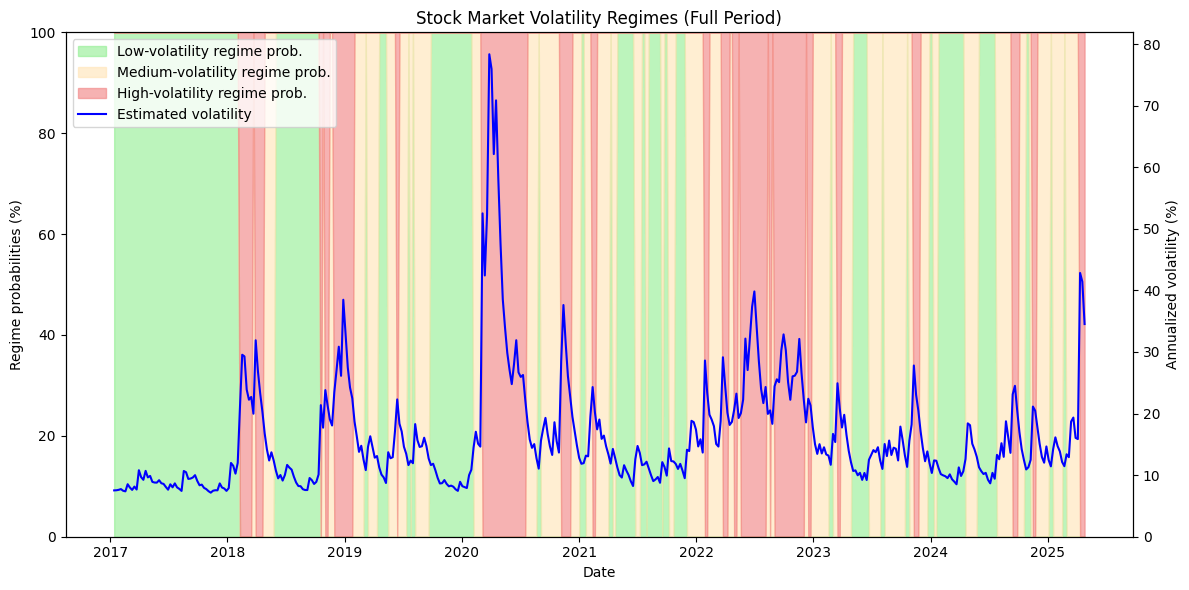

[*********************100%***********************]  1 of 1 completed


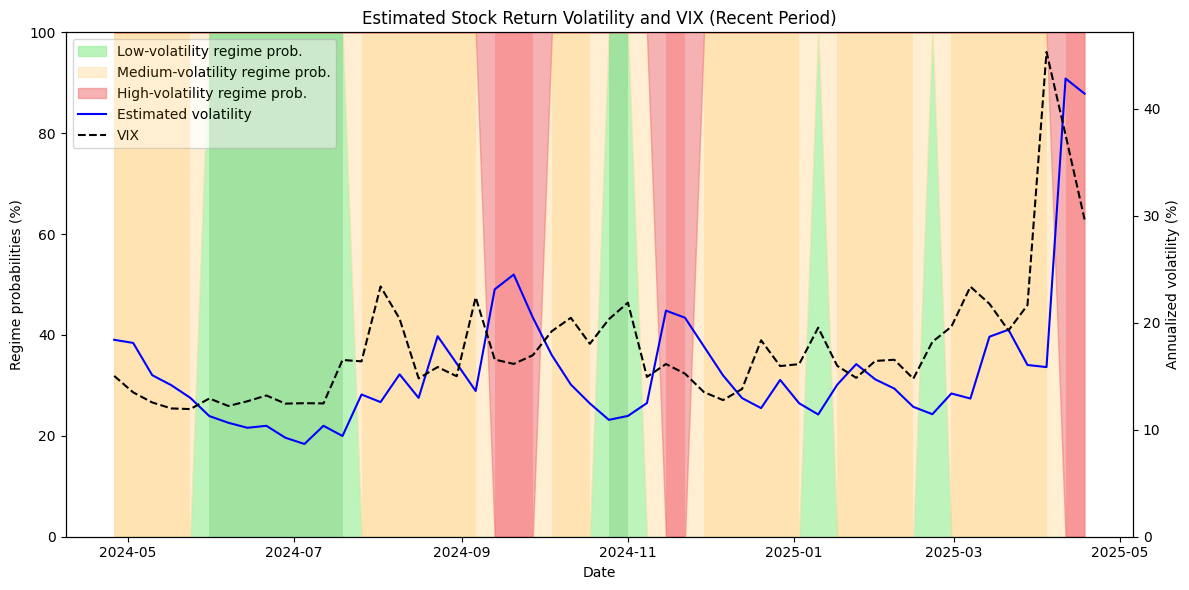

In [77]:
def main():
    # Fetch data using yfinance
    ticker = '^GSPC'  # Imput ticker
    print(f"Fetching {ticker} data from Yahoo Finance...")
    
    # Download data from 1928 or earliest available
    stock = yf.download(ticker, start=start_date)['Close']
    
    # Resample to weekly and calculate returns
    stock_weekly = stock.resample('W-FRI').last()
    stock_weekly = pd.DataFrame(stock_weekly)  # Convert Series to DataFrame
    stock_weekly.columns = ['Close']  # Rename column
    stock_weekly['returns'] = stock_weekly['Close'].pct_change() * 100
    
    # Remove NaN values
    stock_weekly = stock_weekly.dropna()
    
    returns = stock_weekly['returns']
    
    print(f"Data loaded: {len(returns)} weekly observations from {returns.index[0].strftime('%Y-%m-%d')} to {returns.index[-1].strftime('%Y-%m-%d')}")
    print('\n')
    # Fit SWARCH model (simplified version)
    garch_result, conditional_vol, regime_probs = fit_swarch_model(returns)    
    # Calculate regime statistics
    calculate_regime_statistics(returns, regime_probs)
    
    # Plot results
    plot_results(returns, conditional_vol, regime_probs)
    
    # Plot recent period 
    try:
        recent_start = (datetime.now() - timedelta(days=365)).strftime('%Y-%m-%d')
        recent_end = datetime.now().strftime('%Y-%m-%d')
        plot_results(returns, conditional_vol, regime_probs, 
                    start_date=recent_start, end_date=recent_end)
    except Exception as e:
        print(f"Could not create recent period chart: {e}")
        
    return returns, garch_result, conditional_vol, regime_probs


if __name__ == "__main__":
    returns, garch_result, conditional_vol, regime_probs = main()



--- Generating Forecast for next 30 days ---
Forecasting 5 weekly steps...

Forecast Results:
            Forecasted Volatility Predicted Regime
2025-05-02              28.637030  high_volatility
2025-05-09              28.904156  high_volatility
2025-05-16              29.168836  high_volatility
2025-05-23              29.431135  high_volatility
2025-05-30              29.691118  high_volatility

Disclaimer:
 - Forecast is based on the fitted simplified SWARCH (GARCH + Thresholds) model.
 - Assumes model parameters and market dynamics remain stable.
 - GARCH forecasts tend to revert to the long-term average volatility.
 - Real-world volatility can deviate significantly from forecasts.


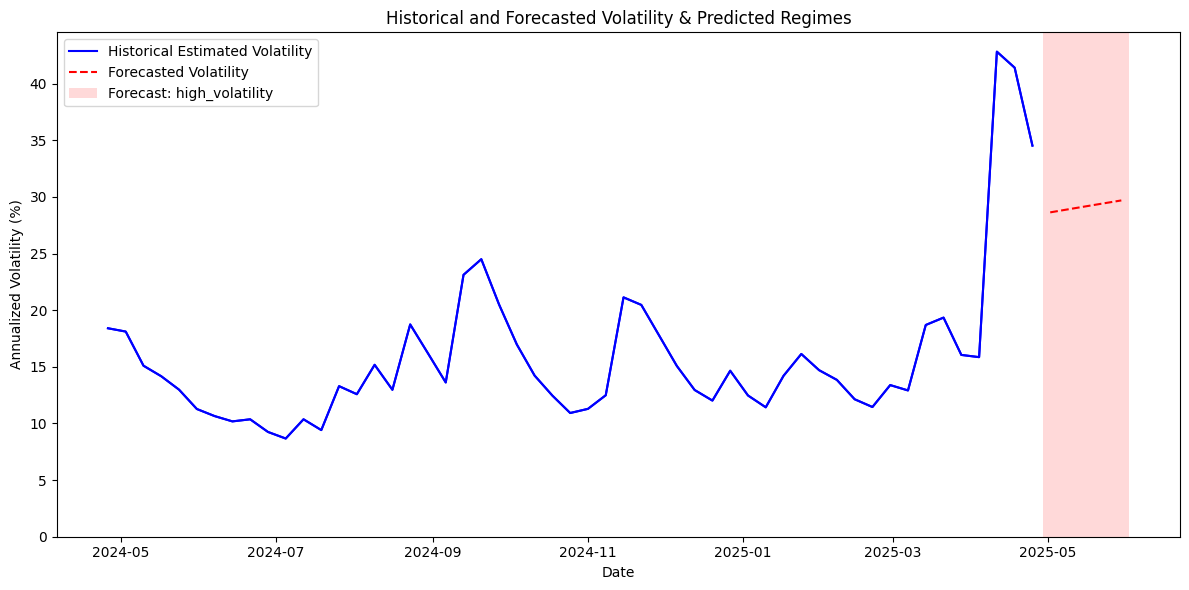

In [79]:

def forecast_volatility_regimes(garch_result, last_returns, low_thresh, high_thresh, forecast_horizon_days=30):
    """
    Forecasts volatility and regimes for a specified number of days ahead.

    Args:
        garch_result: The fitted GARCH model result object from arch.fit().
        last_returns (pd.Series): The most recent returns data used for fitting.
                                     Needed by some forecast methods if using simulation,
                                     but primarily used here to get the last date.
        low_thresh (float): Threshold for low volatility regime.
        high_thresh (float): Threshold for high volatility regime.
        forecast_horizon_days (int): Number of days to forecast ahead.

    Returns:
        pd.DataFrame: A DataFrame containing forecasted volatility and predicted regime.
    """
    print(f"\n--- Generating Forecast for next {forecast_horizon_days} days ---")

    # --- 1. Forecast Volatility using the GARCH model ---
    # Calculate the number of weekly steps needed
    # Use ceil to ensure we cover the full number of days
    steps = int(np.ceil(forecast_horizon_days / 7))
    print(f"Forecasting {steps} weekly steps...")

    # Use the forecast method of the fitted GARCH result
    # 'reindex=False' gives direct step-ahead forecasts without aligning to an index
    forecasts = garch_result.forecast(horizon=steps, reindex=False)

    # Extract the forecasted conditional variance (h.1, h.2, ...)
    # .values[0] accesses the first row (and typically only row) of forecast results
    forecasted_variance = forecasts.variance.values[0]

    # Convert variance to annualized volatility
    forecasted_volatility_annualized = np.sqrt(forecasted_variance) * np.sqrt(52)

    # --- 2. Create Future Date Index ---
    last_date = last_returns.index[-1]
    # Generate weekly dates starting from the week AFTER the last known date
    future_dates = pd.date_range(start=last_date + timedelta(days=1), periods=steps, freq='W-FRI')

    # Create a Series for the forecasted volatility
    forecasted_vol_series = pd.Series(forecasted_volatility_annualized, index=future_dates, name='Forecasted Volatility')

    # --- 3. Predict Regimes based on Forecasted Volatility ---
    # Apply the same threshold logic used in fit_swarch_model
    predicted_regimes_numeric = pd.Series(1, index=future_dates)  # Default to medium (1)
    predicted_regimes_numeric[forecasted_vol_series <= low_thresh] = 0 # Low (0)
    predicted_regimes_numeric[forecasted_vol_series > high_thresh] = 2  # High (2)

    # Map numeric regimes to labels
    regime_map = {0: 'low_volatility', 1: 'medium_volatility', 2: 'high_volatility'}
    predicted_regimes_labels = predicted_regimes_numeric.map(regime_map)
    predicted_regimes_labels.name = 'Predicted Regime'

    # --- 4. Combine Results ---
    forecast_df = pd.concat([forecasted_vol_series, predicted_regimes_labels], axis=1)

    print("\nForecast Results:")
    print(forecast_df)

    # --- 5. Disclaimer ---
    print("\nDisclaimer:")
    print(" - Forecast is based on the fitted simplified SWARCH (GARCH + Thresholds) model.")
    print(" - Assumes model parameters and market dynamics remain stable.")
    print(" - GARCH forecasts tend to revert to the long-term average volatility.")
    print(" - Real-world volatility can deviate significantly from forecasts.")

    return forecast_df

def plot_forecast(conditional_vol, forecast_df):
    """
    Plots the recent historical volatility and the forecasted volatility.
    """
    if forecast_df.empty:
        print("Forecast DataFrame is empty, cannot plot.")
        return

    fig, ax = plt.subplots(figsize=(12, 6))

    # Plot recent historical volatility (e.g., last year)
    if not conditional_vol.empty:
        start_date_plot = conditional_vol.index.max() - pd.DateOffset(weeks=52)
        # Use .loc slicing - handles cases where data is shorter than 52 weeks
        recent_hist_vol = conditional_vol.loc[start_date_plot:]
        ax.plot(recent_hist_vol.index, recent_hist_vol, label='Historical Estimated Volatility', color='blue')
    else:
        print("Conditional volatility data is empty, cannot plot historical part.")
    ax.plot(recent_hist_vol.index, recent_hist_vol, label='Historical Estimated Volatility', color='blue')

    # Plot forecasted volatility
    ax.plot(forecast_df.index, forecast_df['Forecasted Volatility'], label='Forecasted Volatility', color='red', linestyle='--')

    # Add shading based on predicted regime for the forecast period
    alpha_shade = 0.15
    for regime, color in [('low_volatility', 'green'), ('medium_volatility', 'orange'), ('high_volatility', 'red')]:
        regime_periods = forecast_df[forecast_df['Predicted Regime'] == regime]
        if not regime_periods.empty:
             # Simple way to shade: iterate through forecast points
             # More robust: group consecutive dates and use axvspan
             start_p = None
             for date in regime_periods.index:
                 if start_p is None: start_p = date
                 # If next date isn't consecutive week or it's the last point, draw span
                 next_date_expected = date + pd.Timedelta(weeks=1)
                 if (date == regime_periods.index[-1]) or (forecast_df.index[forecast_df.index.get_loc(date) + 1] != next_date_expected) :
                      end_p = date + pd.Timedelta(days=3) # Extend span slightly for visibility
                      ax.axvspan(start_p - pd.Timedelta(days=3), end_p, color=color, alpha=alpha_shade, lw=0, label=f'Forecast: {regime}' if start_p == regime_periods.index[0] else "") # Label only first span
                      start_p = None


    ax.set_ylabel('Annualized Volatility (%)')
    ax.set_xlabel('Date')
    ax.set_title('Historical and Forecasted Volatility & Predicted Regimes')

    # Improve legend handling - avoid duplicate labels from axvspan
    handles, labels = ax.get_legend_handles_labels()
    by_label = dict(zip(labels, handles)) # Use dict to automatically remove duplicates
    ax.legend(by_label.values(), by_label.keys(), loc='upper left')

    ax.set_ylim(bottom=0)
    plt.tight_layout()
    plt.show()


# --- HOW TO USE IT ---
# Make sure you have run the cell with main() first, and that
# garch_result, returns, conditional_vol are available.

# Define the thresholds used in fit_swarch_model
low_thresh_forecast = 12
high_thresh_forecast = 20

# Check if garch_result exists (important if running cells out of order)
if 'garch_result' in locals() or 'garch_result' in globals():
    # Generate the forecast
    forecast_results = forecast_volatility_regimes(
        garch_result,
        returns, # Pass the returns Series used for fitting
        low_thresh_forecast,
        high_thresh_forecast,
        forecast_horizon_days=30
    )

    # Plot the forecast alongside recent history
    if 'conditional_vol' in locals() or 'conditional_vol' in globals():
        plot_forecast(conditional_vol, forecast_results)
    else:
        print("Variable 'conditional_vol' not found. Cannot plot forecast.")

else:
    print("Variable 'garch_result' not found. Please run the main analysis cell first.")